### Importing Data and Important Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm    
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from prophet import Prophet

In [2]:
data = pd.read_csv('train_1.csv')

In [3]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### Feature Engineering

In [4]:
def parse_page_name(page_name):
    parts = page_name.split("_")
    if len(parts) >= 4:
        title = "_".join(parts[:-3])
        language = parts[-3].split('.')[0]
        access_type = parts[-2]
        access_origin = parts[-1]
        return title, language, access_type, access_origin
    return None, None, None, None

# Apply the function to the `page_name` column and expand results into new columns
data[["Title", "Language", "Access Type", "Access Origin"]] = data["Page"].apply(parse_page_name).apply(pd.Series)


In [5]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access Type,Access Origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,zh,all-access,spider


In [6]:
data = data.melt(id_vars=["Page", "Title", "Language", "Access Type", "Access Origin"], var_name="Date", value_name="Value")

In [7]:
data.head()

,Page,Title,Language,Access Type,Access Origin,Date,Value
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access,spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,zh,all-access,spider,2015-07-01,NaN


### Checking Basic Metrics

In [8]:
data.shape

(79784650, 7)

In [9]:
data.size

558492550

In [10]:
data.isna().sum()

Page                   0
Title                  0
Language               0
Access Type            0
Access Origin          0
Date                   0
Value            6192931
dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79784650 entries, 0 to 79784649
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Page           object 
 1   Title          object 
 2   Language       object 
 3   Access Type    object 
 4   Access Origin  object 
 5   Date           object 
 6   Value          float64
dtypes: float64(1), object(6)
memory usage: 4.2+ GB


In [12]:
data.describe()

,Value
count,7.359172e+07
mean,1.419986e+03
std,8.669325e+04
min,0.000000e+00
25%,1.900000e+01
50%,1.470000e+02
75%,6.670000e+02
max,6.726426e+07


### Some of the columns are don't have language so replacing them with unknown

In [13]:
data["Language"] = data["Language"].replace(["www", "commons"], "unknown")

In [14]:
(data['Date'].min() , data['Date'].max())

('2015-07-01', '2016-12-31')

In [15]:
data['Date'].value_counts()

Date
2016-12-31    145063
2015-07-01    145063
2015-07-02    145063
2015-07-03    145063
2015-07-04    145063
               ...  
2015-07-11    145063
2015-07-10    145063
2015-07-09    145063
2015-07-08    145063
2015-07-07    145063
Name: count, Length: 550, dtype: int64

### Quick Analysis

- Here the every date has 145063 columns so it means every page has data for every date in the dataset
- Filling the missing Nan using linear interpolation because filling the value with mean might create an discrepancy in the data

### Imputing Nan values using Linear Interpolation

In [16]:
data['Value'] = data['Value'].interpolate(method='linear')

In [17]:
data.isna().sum()

Page             0
Title            0
Language         0
Access Type      0
Access Origin    0
Date             0
Value            0
dtype: int64

### Renaming the Language column names

In [18]:
data['Language'].value_counts()

Language
en         13259400
ja         11237050
de         10200850
unknown     9820250
fr          9791100
zh          9475950
ru          8262100
es          7737950
Name: count, dtype: int64

In [19]:
language_map = {
    "en": "English",
    "ja": "Japanese",
    "de": "German",
    "fr": "French",
    "zh": "Chinese",
    "ru": "Russian",
    "es": "Spanish"
}

data['Language'] = data['Language'].map(language_map)

In [20]:
data.head()

,Page,Title,Language,Access Type,Access Origin,Date,Value
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,Chinese,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,Chinese,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,3C,Chinese,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,Chinese,all-access,spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,Chinese,all-access,spider,2015-07-01,23.5


### Non Graphical Analysis

In [21]:
col=['Access Type', 'Access Origin', 'Language']
for i in col:
    print("Value count of :",i)
    print(data[i].value_counts())
    print()
    print("-"*100)

Value count of : Access Type
Access Type
all-access    40873250
mobile-web    19766450
desktop       19144950
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
Value count of : Access Origin
Access Origin
all-agents    60582500
spider        19202150
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
Value count of : Language
Language
English     13259400
Japanese    11237050
German      10200850
French       9791100
Chinese      9475950
Russian      8262100
Spanish      7737950
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------


### Graphical Analysis

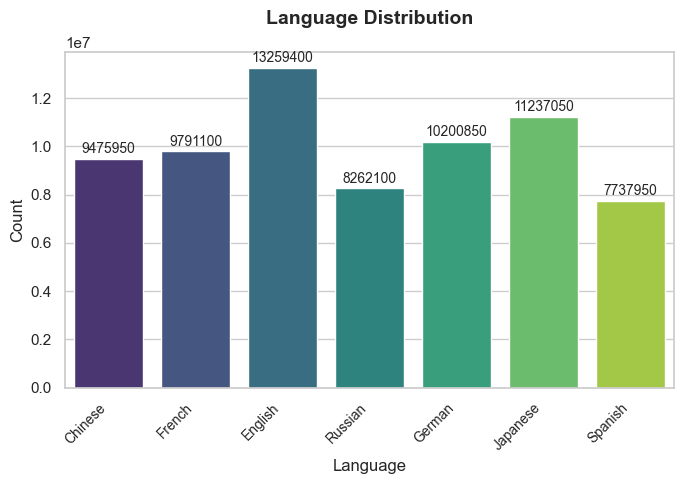

In [22]:
plt.figure(figsize=(7, 5))  
sns.set_theme(style="whitegrid")  
ax = sns.countplot(data=data, x="Language", palette="viridis")  

# Add labels and a title
ax.set_title("Language Distribution", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Language", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Improve readability of x-axis
plt.xticks(rotation=45, fontsize=10, ha="right")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=2)

# Show the plot
plt.tight_layout()
plt.show()

### Insights:

- Around 17% of the pages are in English, making it the most common language.
- Japanese comes next, with about 14% of the pages.
- The remaining languages each make up roughly 12% of the total.

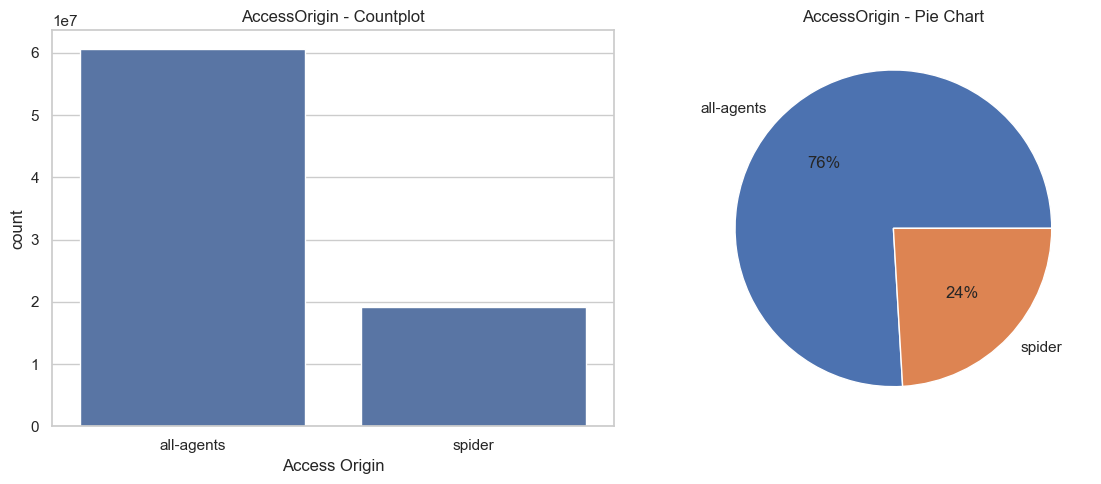

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Countplot
sns.countplot(data=data, x="Access Origin", ax=axes[0], order=data["Access Origin"].value_counts().index)
axes[0].set_title("AccessOrigin - Countplot")

# Pie chart
labels = data["Access Origin"].value_counts().index 
counts = data["Access Origin"].value_counts().values

axes[1].pie(counts, labels=labels, autopct='%1.0f%%')
axes[1].set_title("AccessOrigin - Pie Chart")

plt.tight_layout()
plt.show()

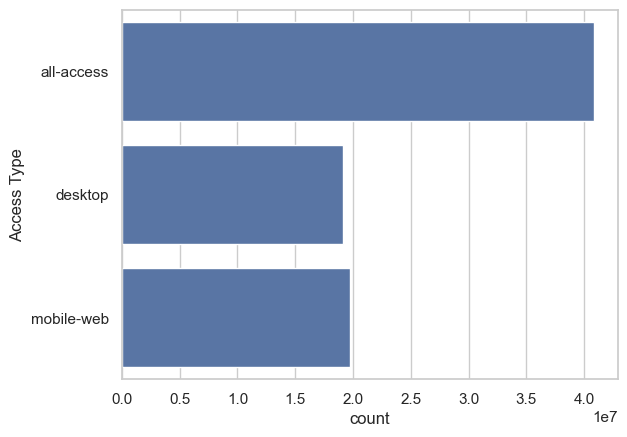

In [24]:
sns.countplot(y=data["Access Type"])
plt.show()

### Bivariate Analysis

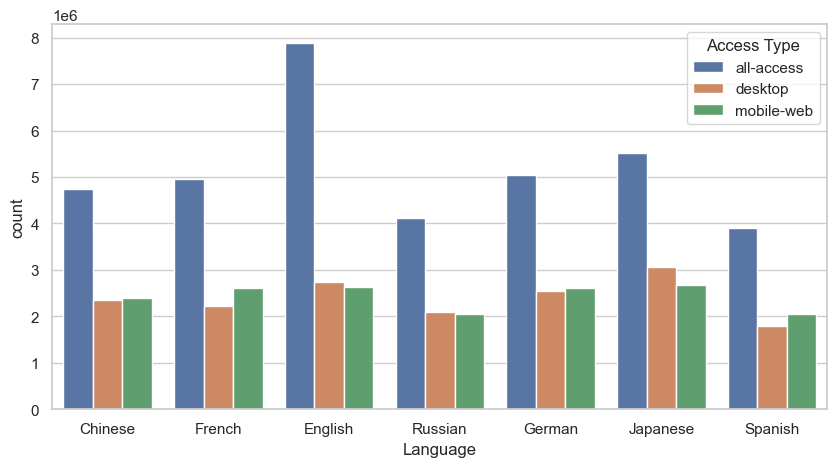

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(data=data,x="Language",hue="Access Type")
plt.show()

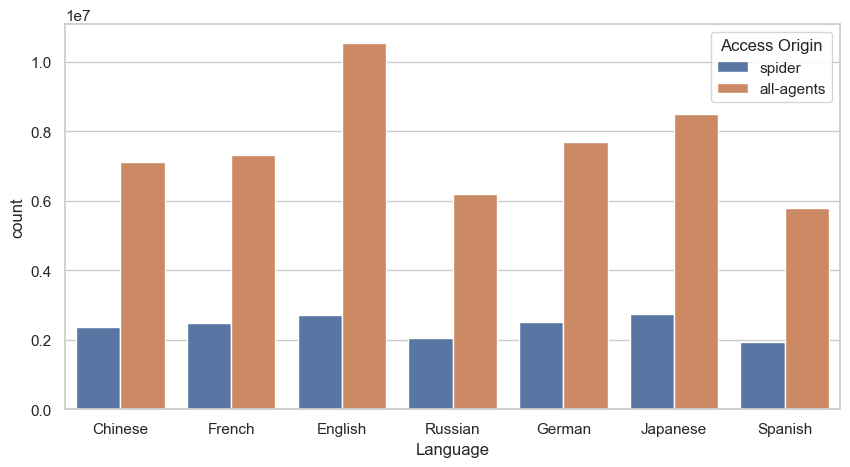

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(data=data,x="Language",hue="Access Origin")
plt.show()

In [27]:
data.head()

,Page,Title,Language,Access Type,Access Origin,Date,Value
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,Chinese,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,Chinese,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,3C,Chinese,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,Chinese,all-access,spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,Chinese,all-access,spider,2015-07-01,23.5


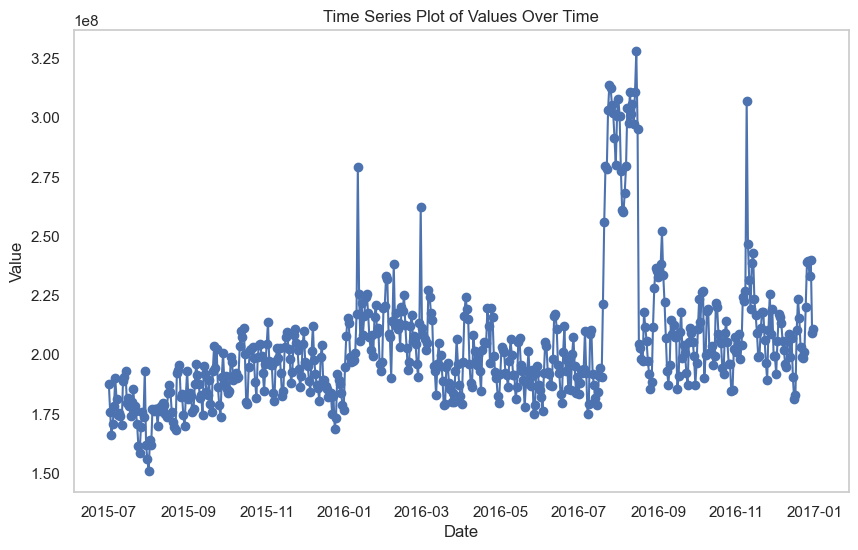

In [28]:
data["Date"] = pd.to_datetime(data["Date"])
data_grouped = data.groupby("Date").sum(numeric_only=True).reset_index()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data_grouped["Date"], data_grouped["Value"], marker='o')
plt.title("Time Series Plot of Values Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.show()

In [29]:
data.set_index('Date', inplace=True)

In [30]:
reshaped_df = data.pivot_table(index=data.index, columns='Language', values='Value', aggfunc='mean')

In [31]:
reshaped_df.columns.name = None

In [32]:
reshaped_df

,Chinese,English,French,German,Japanese,Russian,Spanish
Date,,,,,,,
2015-07-01,302.355734,4427.708334,1129.034804,790.590708,601.360077,651.452513,1209.999028
2015-07-02,268.117246,4392.444278,502.047865,775.655888,687.995484,655.053777,1160.690263
2015-07-03,267.042942,4166.937545,484.547462,745.781675,616.659299,609.369040,1056.775572
2015-07-04,259.622370,4322.986667,526.252510,678.666147,776.318452,572.553909,992.093234
2015-07-05,277.441749,4482.500642,507.830786,791.054515,750.043471,628.859743,1077.254428
...,...,...,...,...,...,...,...
2016-12-27,379.421063,6063.200286,859.794574,1116.103251,809.202535,1003.665424,1158.402587
2016-12-28,382.057316,5889.543575,776.484440,1063.900065,810.996280,934.810545,1205.360118
2016-12-29,354.920570,6268.441202,754.271205,1022.153879,887.976041,900.150945,1134.710463


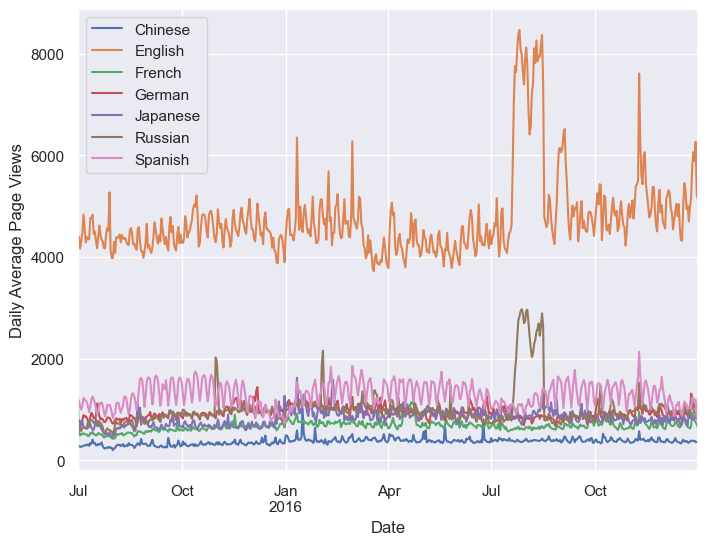

In [33]:
plt.figure(figsize=(8, 6))
sns.set_theme()
reshaped_df.plot(ax=plt.gca())  
plt.xlabel("Date")
plt.ylabel("Daily Average Page Views")
plt.show()

### Insight
- English pages are the most visited pages follwed by Spanish
- English pages have an upward trend in terms of visits
- There is an unusual peak from mid of July to end of August 2016

### Checking if the data is Stationary

- Null Hypothesis: Data is Not stationary
- Alternate Hypothesis: Data is stationary

In [34]:
def dicky_fuller(data, alpha):
    result = adfuller(data)
    if result[1] < alpha:
        print(f"The data is Stationary {result[1].round(2)}")
    else:
        print(f"The data is non stationary {result[1].round(2)}")

In [35]:
for i in reshaped_df.columns:
    print(i)
    dicky_fuller(reshaped_df[i], 0.05)
    print()

Chinese
The data is non stationary 0.22

English
The data is non stationary 0.06

French
The data is Stationary 0.03

German
The data is non stationary 0.1

Japanese
The data is non stationary 0.08

Russian
The data is Stationary 0.0

Spanish
The data is non stationary 0.05



### Making the data Stationary for language English only

In [36]:
English = reshaped_df['English']

In [37]:
English

Date
2015-07-01    4427.708334
2015-07-02    4392.444278
2015-07-03    4166.937545
2015-07-04    4322.986667
2015-07-05    4482.500642
                 ...     
2016-12-27    6063.200286
2016-12-28    5889.543575
2016-12-29    6268.441202
2016-12-30    5217.368425
2016-12-31    5139.305521
Name: English, Length: 550, dtype: float64

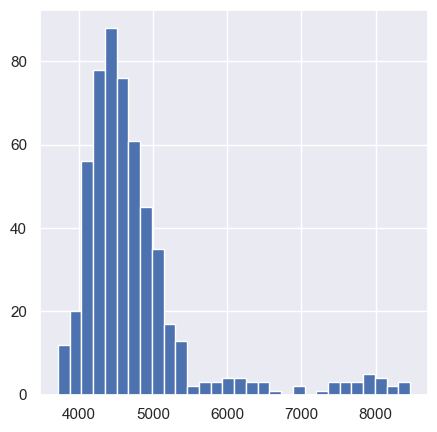

In [38]:
plt.figure(figsize=(5,5))
English.hist(bins=30);

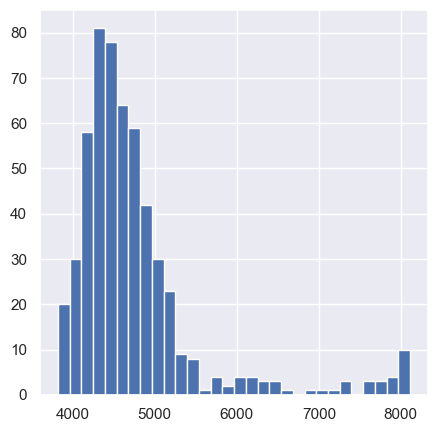

In [39]:
plt.figure(figsize=(5,5))
English_clipped = English.clip(lower=English.quantile(0.01),upper=English.quantile(0.99))
English_clipped.hist(bins=30);

### Decomposing the data for english Language using Triple Exponential Smoothing

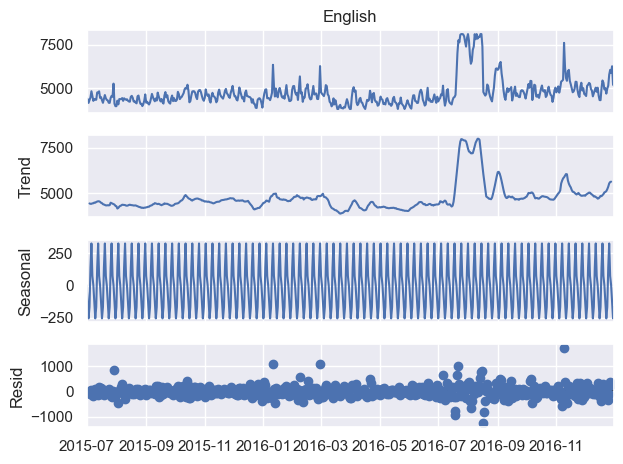

In [40]:
decomp_english = sm.tsa.seasonal_decompose(English_clipped)
decomp_english.plot();

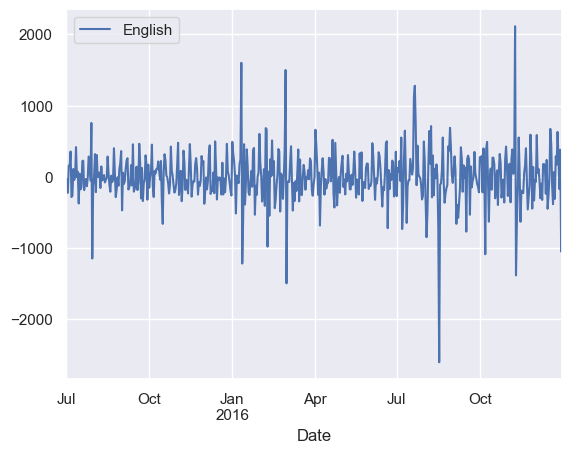

In [41]:
English_clipped.diff().plot()
plt.legend()

### Checking the Stationary of the Data 

In [42]:
dicky_fuller(English_clipped.diff().dropna(), 0.05)

The data is Stationary 0.0


In [43]:
Stationary_data = English_clipped.diff().dropna()

In [44]:
Stationary_data

Date
2015-07-02     -35.264056
2015-07-03    -225.506733
2015-07-04     156.049122
2015-07-05     159.513974
2015-07-06     354.473387
                 ...     
2016-12-27     279.345881
2016-12-28    -173.656711
2016-12-29     378.897627
2016-12-30   -1051.072777
2016-12-31     -78.062904
Name: English, Length: 549, dtype: float64

### Plotting ACF and PACF plot

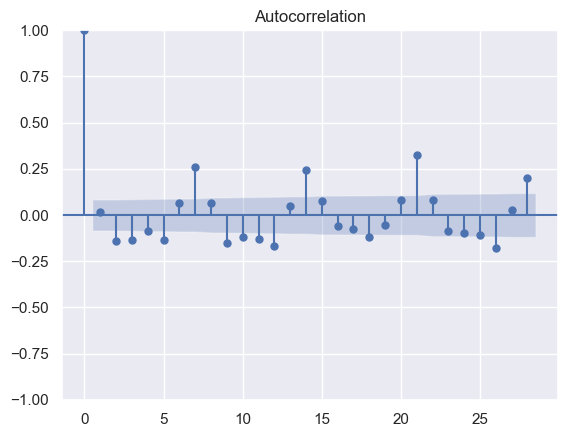

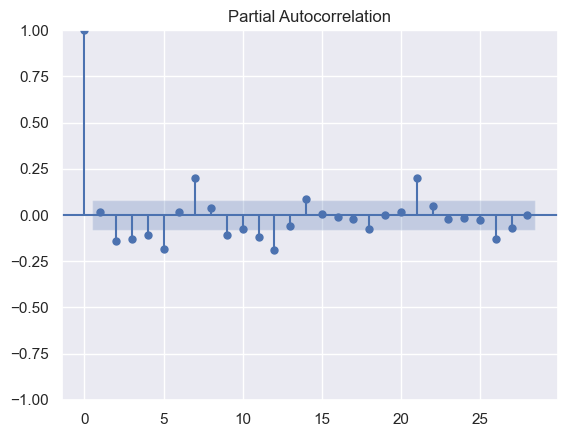

In [45]:
sm.tsa.graphics.plot_acf(Stationary_data);
sm.tsa.graphics.plot_pacf(Stationary_data);

### ACF (Autocorrelation Function):
- Significant spikes at lags 7, 14, and 21 (visible well above the confidence band).
- This pattern suggests seasonality (possibly weekly, every 7 days).
- Indicates potential values for q = 1, 2, or 3.

### PACF (Partial Autocorrelation Function):
- Significant spikes at lags 7 and 21.
- Gradual decline after lag 1.
- Indicates potential values for p = 1 or 2.

### Modeling

In [46]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

### Arima Model

MAE : 272.444
RMSE : 347.019
MAPE: 1.006



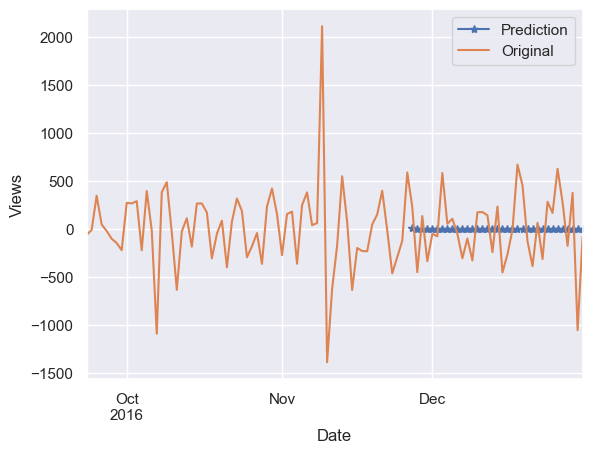

In [47]:
X_train, X_test = Stationary_data.iloc[:-35], Stationary_data.iloc[-35:]

# Fit the ARIMA model
model = sm.tsa.ARIMA(endog=X_train, order=(1,1,1), seasonal_order=(0,0,0,0))
result = model.fit()

# Make predictions
predTest = result.forecast(len(X_test))

# Plot the predictions and the original data
predTest.plot(style="-*", label="Prediction")
Stationary_data.tail(100).plot(label="Original")
plt.ylabel("Views")
plt.xlabel("Date")
plt.legend()

# Evaluate the performance of the model
performance(X_test, predTest)
print()

In [48]:
exog = pd.read_csv('Exog_Campaign_eng.csv')

In [49]:
X_train_exog, X_test_exog = exog.iloc[:-36], exog.iloc[-35:]

In [50]:
X_train.index = X_train_exog.index

In [51]:
model = SARIMAX(
    X_train,
    exog=X_train_exog,          
    order=(1, 1, 1),           
    seasonal_order=(1, 1, 1, 12)  
)

# Fit the model
fit = model.fit(disp=False)

In [52]:
forecast = fit.forecast(steps=len(X_test), exog=X_test_exog)

                                     SARIMAX Results                                      
Dep. Variable:                            English   No. Observations:                  514
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3714.472
Date:                            Mon, 21 Apr 2025   AIC                           7440.944
Time:                                    12:11:44   BIC                           7466.243
Sample:                                         0   HQIC                          7450.871
                                            - 514                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exog       -1435.7917     57.935    -24.783      0.000   -1549.342   -1322.241
ar.L1          0.2925      0.055   

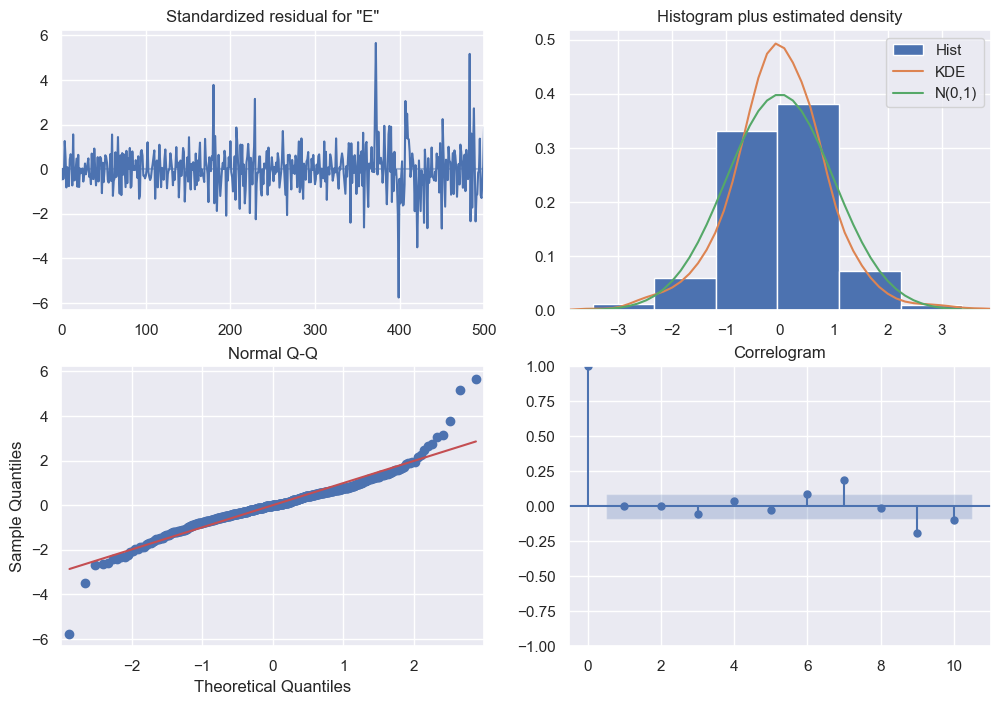

In [53]:
print(fit.summary())

# Plot diagnostics
fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [54]:
performance(X_test, forecast)

MAE : 430.316
RMSE : 575.243
MAPE: 3.067


In [80]:
X_train, X_test = English_clipped.iloc[:-35], English_clipped.iloc[-35:]

In [84]:
X_train_exog, X_test_exog = exog.iloc[:-35], exog.iloc[-35:]

In [85]:
X_train.index = X_train_exog.index

In [55]:
# Define parameter ranges
p = range(0, 3)  # AR order
d = range(0, 2)  # Differencing order
q = range(0, 3)  # MA order
P = range(0, 3)  # Seasonal AR order
D = range(0, 2)  # Seasonal differencing order
Q = range(0, 3)  # Seasonal MA order
s = [12]         # Seasonal period (e.g., monthly data)

# Create all combinations of parameters
param_grid = list(itertools.product(p, d, q, P, D, Q, s))

In [56]:
results = []

# Iterate over parameter combinations
for params in param_grid:
    try:
        # Define the SARIMAX model
        model = SARIMAX(
            X_train,
            order=(params[0], params[1], params[2]),
            seasonal_order=(params[3], params[4], params[5], params[6]),
            exog=X_train_exog  # Include exogenous variables if available
        )
        # Fit the model
        fit = model.fit(disp=False)

        # Save parameters and evaluation metric
        results.append({
            'params': params,
            'aic': fit.aic,
            'bic': fit.bic
        })
    except Exception as e:
        # Save failed parameter combination
        results.append({
            'params': params,
            'aic': None,
            'bic': None,
            'error': str(e)
        })

In [58]:
results_df = pd.DataFrame(results)

# Drop rows with errors or NaN AIC
results_df = results_df.dropna(subset=['aic'])

# Sort by AIC
best_model = results_df.sort_values(by='aic').iloc[0]

# Display the best parameters
print("Best Parameters:", best_model['params'])
print("AIC:", best_model['aic'])

Best Parameters: (1, 0, 1, 1, 1, 2, 12)
AIC: 14.0


In [86]:
best_params = best_model['params']

# Refit the model with best parameters
final_model = SARIMAX(
    X_train,
    order=(best_params[0], best_params[1], best_params[2]),
    seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
    exog=X_train_exog
).fit(disp=False)

# Forecast using the final model
forecast = final_model.forecast(steps=len(X_test), exog=X_test_exog)

                                     SARIMAX Results                                      
Dep. Variable:                            English   No. Observations:                  514
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3739.551
Date:                            Mon, 21 Apr 2025   AIC                           7499.101
Time:                                    12:51:10   BIC                           7541.267
Sample:                                         0   HQIC                          7515.646
                                            - 514                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exog       -1453.9972     91.914    -15.819      0.000   -1634.145   -1273.850
ar.L1         -0.7339      0.307   

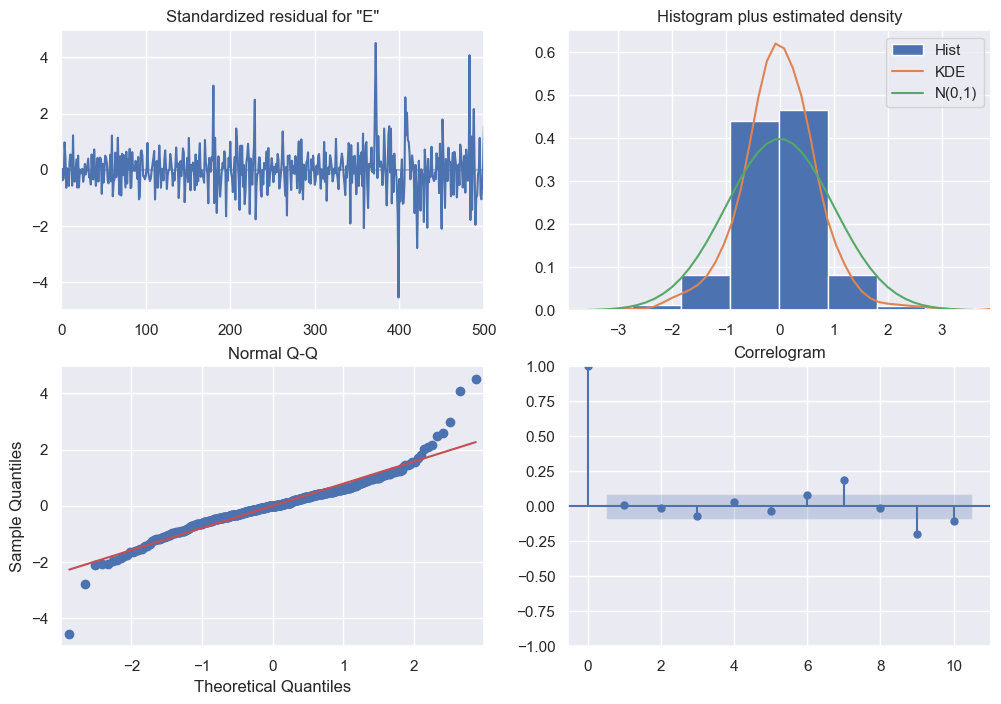

In [61]:
print(fit.summary())

# Plot diagnostics
fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [87]:
performance(X_test, forecast)

MAE : 396.736
RMSE : 473.142
MAPE: 0.076


### Predicting the future Values using SARIMAX

In [63]:
ex=exog['Exog'].to_numpy()

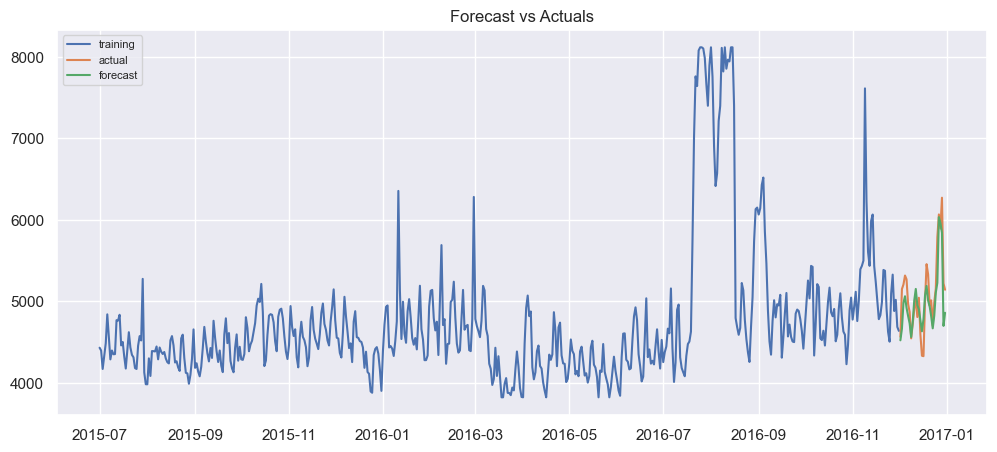

In [88]:
train=English_clipped[:520]
test=English_clipped[520:]
model=sm.tsa.statespace.SARIMAX(train,order=(4, 1, 3),seasonal_order=(1,1,1,7),exog=ex[:520])
results=model.fit()

fc=results.forecast(30,dynamic=True,exog=pd.DataFrame(ex[520:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### FB Prophet

In [95]:
df = English_clipped.reset_index()

In [96]:
df.rename(columns={'Date': 'ds', 'English': 'y'}, inplace=True)

13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:10:39 - cmdstanpy - INFO - Chain [1] done processing


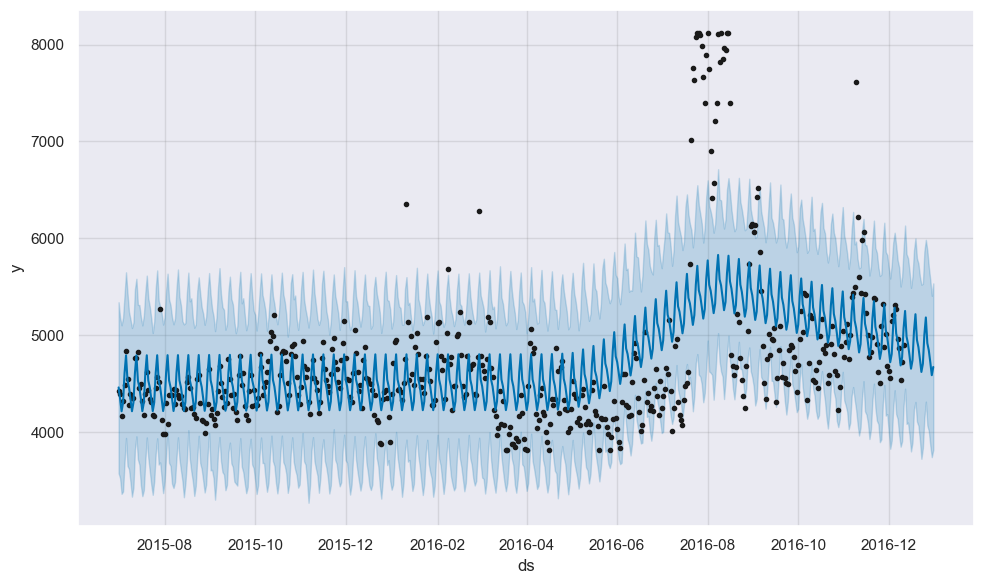

In [97]:
m = Prophet(weekly_seasonality=True)
m.fit(df[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

### Running FB Prophet using Exogeneous Variable

In [101]:
df['exog'] = exog

13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


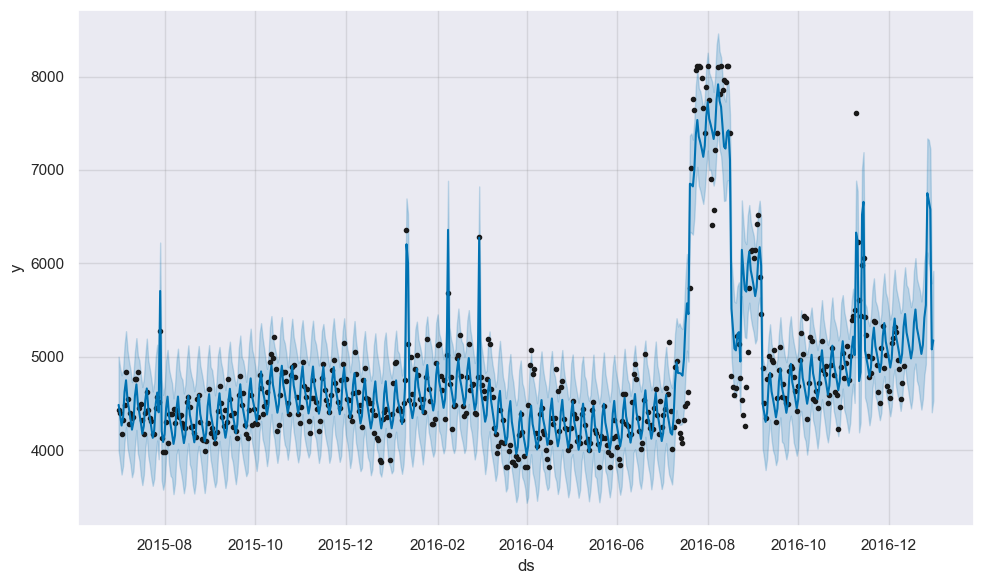

In [102]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog')
model2.fit(df[:-20])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

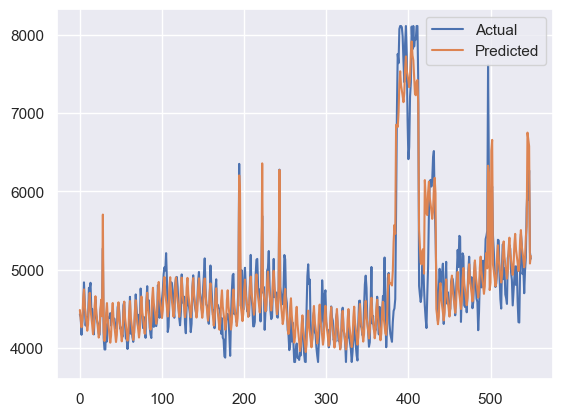

In [104]:
y_true = df['y'].values
y_pred = forecast2['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
     

In [105]:
mape = np.mean(np.abs(forecast2['yhat'][-20:] - df['y'][-20:].values)/np.abs(df['y'][-20:].values))
print("mape:",mape)

mape: 0.06620436903062904


- Fb prophet - 6.6% Mape
- Sarimax - 7.6% Mape

### Recommendations based on MAPE & mean_visits:

- English language is a clear winner. Maximum advertisement should be done on English pages. Their MAPE is low & mean visits are high.

- Chinese language has lowest number of visits. Advertisements on these pages should be avoided unless business has specific marketing strategy for Chinese populations.

- Russian language pages have decent number of visits and low MAPE. If used properly, these pages can result in maximum conversion.

- Spanish language has second highest number of visits but their MAPE is highest. There is a possibility advertisements on these pages won't reach the final people.

- French, German & Japenese have medium level of visits & medium MAPE levels.

- Depending on target customers advertisements should be run on these pages.

## Questions

### Defining the problem statements and where can this and modifications of this be used?
- We are provided with the data of 145k wikipedia pages and daily view count for each of them. Our clients belong to different regions and need data on how their ads will perform on pages in different languages. By creating a proper forecasting model to predict the fluctuations of visits on pages, we can help the business team to optimise the marketing spend. If we can predict the days with higher visits properly, the business will run the ads for those specific days and still be able to reach wider audience with most optimized spend.

### Write 3 inferences you made from the data visualizations
- All-agents access is significantly higher than spider access across all languages, with English having the highest overall count.
- Japanese and German also show high engagement from all-agents, while Spanish and Russian have the lowest counts in both categories.
- English has more pages with AccessType of all-access, different from the rest
- English pages are the most visited pages follwed by Spanish
- English pages have an upward trend in terms of visits
- There is an unusual peak from mid of July to end of August 2016

### What does the decomposition of series do?
- The decomposition of a time series is a technique used to separate the series into its constituent components.

### What level of differencing gave you a stationary series?
- Level 1 (diff(1))

### Difference between arima, sarima & sarimax
- ARIMA:
    - Models non-seasonal time series.
    - No seasonality or external factors.
- SARIMA:
    - Extends ARIMA to handle seasonality.
    - No external factors.
- SARIMAX:
    - Extends SARIMA by including external predictors (exogenous variables).
    - Handles seasonality and external factors.

### Compare the number of views in different languages
- Mean number of views (Popularity sequence) of various languages have the following : English > Spanish > Russian > German > Japenese > French > Chinese

### What other methods other than grid search would be suitable to get the model for all languages?
- Bayesian Optimization
- Randomized Search